# Phase 1 - Unconditional Diffusion

What 'unconditional diffusion' means in this project: I downloaded a folder of real cell images (my dataset). I want to train a model that can:

- learn what 'a realistic cell image' looks like, and
- generate new ones from scratch (starting from random noise),
- without using:
    - the class label (neutrophil, lymphocyte, etc), and
    - without masks or any other conditioning signal.

So the only thing the model learns is the distribution of all cell images combined.


What I expect visually:

- Early in training: samples look like colored noise
- After some training: faint circular "cell blobs"
- Later: nucleus/cytoplasm separation, realistic stain colors, sharper morphology
- If nothing emerges after substantial training, it could mean:
    - normalization issues,
    - too high resolution too early,
    - model too small, or
    - not enough training steps.


Steps:

- Step 0 - Prepare the training images
- Step 1 - Define a noise schedule
- Step 2 - Forward process (add noise to real images)
- Step 3 - Train a U-Net to predict the noise
- Step 4 - Why timestep conditioning is necessary
- Step 5 - Once training is done, we generate a new cell image like this: Start from pure noise, and then
- Step 6 - Reverse process (denoise step-by-step)


## Notes

Great intro on "Diffusion models from scratch in PyTorch "https://www.youtube.com/watch?v=a4Yfz2FxXiY&t=178s

In [2]:
# ============================
# Standard library
# ============================
import os
import random
import shutil
import zipfile
import math
from pathlib import Path
from itertools import product

# ============================
# Scientific / data libraries
# ============================
import numpy as np
import pandas as pd

# ============================
# Visualization
# ============================
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ============================
# Image handling
# ============================
from PIL import Image, ImageFile

# ============================
# PyTorch core
# ============================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# ============================
# PyTorch data utilities
# ============================
from torch.utils.data import Dataset, DataLoader

# ============================
# Torchvision
# ============================
from torchvision import transforms
from torchvision.utils import make_grid


In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
os.chdir("drive/MyDrive/Diffusionmodelsforcellimages/")

In [4]:
#!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/snkd93bnjr-1.zip
#zip_path = "data/snkd93bnjr-1.zip"
#extract_dir = "data/PBC_dataset_normal_DIB"

# Make sure the output directory exists
#os.makedirs(extract_dir, exist_ok=True)

# Extract everything
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_dir)

# Correct path to the zip file
#zip_path = Path("data/PBC_dataset_normal_DIB/A dataset for microscopic peripheral blood cell images for development of automatic recognition systems/PBC_dataset_normal_DIB.zip")

# Directory where the zip file is located
#extract_dir = zip_path.parent

# Destination: two directories up
#destination_dir = extract_dir.parent.parent

# Unzip the file
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_dir)

# Define source and destination
#src = Path("data/PBC_dataset_normal_DIB/A dataset for microscopic peripheral blood cell images for development of automatic recognition systems/PBC_dataset_normal_DIB")
#dst = Path("data/PBC_dataset_normal_DIB_new")

# Move and rename the folder
#shutil.move(str(src), str(dst))
# REmove old folder
#shutil.rmtree("data/PBC_dataset_normal_DIB")

In [5]:
# Split into train / val / test

# Set random seed for reproducibility
#random.seed(42)

# Set paths
#base_dir = Path("data/PBC_dataset_normal_DIB_new")
#output_dir = base_dir.parent / "PBC_dataset_normal_DIB_split"

# Split ratios
#train_ratio = 0.85
#val_ratio = 0.15 # not sure if I'm gonna use it, but just in case
#test_ratio = 0.0 # it's not really nessacery for this model; its unsupervised in the end

# Sanity check
#assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"

# Create output directories
#for split in ["train", "val", "test"]:
#    for cls in os.listdir(base_dir):
#        (output_dir / split / cls).mkdir(parents=True, exist_ok=True)

# Split each class folder
#for cls in os.listdir(base_dir):
#    class_dir = base_dir / cls
#    if not class_dir.is_dir():
#        continue

#    images = list(class_dir.glob("*.jpg"))
#    random.shuffle(images)

#    n_total = len(images)
#    n_train = int(n_total * train_ratio)
#    n_val = int(n_total * val_ratio)

#    train_files = images[:n_train]
#    val_files = images[n_train:n_train + n_val]
#    test_files = images[n_train + n_val:]

#    # Copy files
#    for img_path in train_files:
#        shutil.copy(img_path, output_dir / "train" / cls / img_path.name)
#    for img_path in val_files:
#        shutil.copy(img_path, output_dir / "val" / cls / img_path.name)
#    for img_path in test_files:
#        shutil.copy(img_path, output_dir / "test" / cls / img_path.name)

#print("Dataset successfully split into train/val/test folders.")


In [6]:
# if some files are truncated, .verify() will still fail, but this makes PIL tolerant during open()
#ImageFile.LOAD_TRUNCATED_IMAGES = False  # keep strict for cleaning

#root = Path("data/PBC_dataset_normal_DIB_split")
#quarantine = root.parent / "quarantine_bad_images"
#quarantine.mkdir(exist_ok=True)

#def is_image_ok(p: Path) -> bool:
#    try:
#        with Image.open(p) as im:
#        im.verify()  # verify file integrity
#        return True
#    except Exception:
#        return False

#bad_files = []
#for split in ["train", "val", "test"]:
#    for cls_dir in (root / split).iterdir():
#        if not cls_dir.is_dir():
#            continue
#        for p in cls_dir.glob("*"):
#            # only check common image extensions; skip others
#            if p.suffix.lower() not in {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}:
#                bad_files.append(p)
#                continue
#            if not is_image_ok(p):
#                bad_files.append(p)

#print(f"Found {len(bad_files)} bad files")
#for p in bad_files:
#    dest = quarantine / f"{p.parent.name}__{p.name}"
#    shutil.move(str(p), str(dest))

#print("Moved bad files to:", quarantine)

## Step 0 - Prepare the training images

- Load a real image $x_0$ from the dataset.
- Resize it to e.g. 64×64 or 128×128.
- Normalize it to a stable numeric range (commonly $[-1, 1]$).
- At this point we get a clean image tensor $x_0$.

In [16]:
# Resize images and saved them so that later the computations are faster

#src_root = Path("data/PBC_dataset_normal_DIB_new")
#dst_root = Path("data/PBC_dataset_normal_DIB_64x64")

#image_size = 64
#dst_root.mkdir(parents=True, exist_ok=True)

# ----------------------------
# Resize and save
# ----------------------------
#for class_dir in src_root.iterdir():
#    if not class_dir.is_dir():
#        continue
#
#    dst_class_dir = dst_root / class_dir.name
#    dst_class_dir.mkdir(parents=True, exist_ok=True)
#
#    images = list(class_dir.glob("*.jpg"))
#
#    for img_path in tqdm(images, desc=f"Resizing {class_dir.name}", leave=False):
#        img = Image.open(img_path).convert("RGB")
#        img = img.resize((image_size, image_size), Image.BILINEAR)
#
#        # save as JPEG (fast + small)
#        out_path = dst_class_dir / img_path.name
#        img.save(out_path, format="JPEG", quality=95, subsampling=0)


Number of images: 9634
Shape: torch.Size([3, 64, 64])
Min / Max: -0.8274509906768799 1.0


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

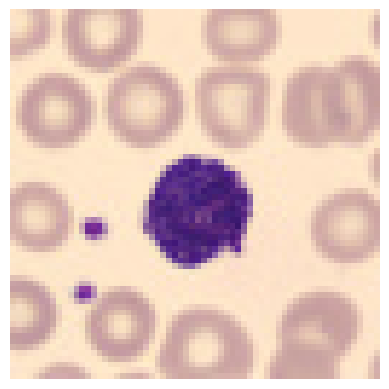

In [5]:

class PBCCellDataset(Dataset):
    def __init__(self, root_dir):
        """
        root_dir: path to e.g. 'train/' directory
        """
        self.root_dir = Path(root_dir)

        # Collect all image paths recursively
        self.image_paths = sorted( p for p in self.root_dir.rglob("*.jpg"))

        if len(self.image_paths) == 0:
            raise RuntimeError(f"No images found in {root_dir}")

        self.transform = transforms.Compose([
            #transforms.Resize((64, image_size)),
            #transforms.RandomHorizontalFlip() # it's not really needed for HandE images, cells are roughly rotationally symmetric
            transforms.ToTensor(),                 # scales data to [0, 1]
            transforms.Lambda(lambda t: t * 2 - 1) # scales data to [-1, 1]
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        x0 = self.transform(img)
        return x0


ds = PBCCellDataset(
    root_dir="data/PBC_dataset_normal_DIB_64x64/")

# SAnity check ---------
print("Number of images:", len(ds))

x0 = ds[0]
print("Shape:", x0.shape)
print("Min / Max:", x0.min().item(), x0.max().item())

# convert back to [0,1] for display
img = (x0 + 1) / 2
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")


## Step 1 - Define a noise schedule

- Lets choose a number of diffusion steps $T$ (often 1000).
- Create a schedule of noise levels:
    - small noise early in the process,
    - large noise later.

This schedule is usually defined through $β1...βT$, from which we compute:

- $αt = 1 - βt$
- $\bar{α}_t = Π_{s=1..t} α_s $(cumulative product)

Intuition: $\bar{α}_t$ tells us "how much of the original image remains" after step $t$.

In [6]:
# Create a DataLoader and grab one batch

BATCH_SIZE = 16
#dl = DataLoader(ds,
#                batch_size=BATCH_SIZE,
#                shuffle=True,
#                drop_last=True)
dl = DataLoader(
    ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=8,              # 4–8?
    pin_memory=True,
    persistent_workers=True,    # keeps workers alive across epochs
    prefetch_factor=2
)

x0_batch = next(iter(dl))  # shape: (B, 3, H, W), values in [-1,1]
print(x0_batch.shape, x0_batch.min().item(), x0_batch.max().item())

torch.Size([16, 3, 64, 64]) -0.8509804010391235 1.0


## Step 2 - Forward process (add noise to real images)

For each training image \(x_0\), do the following:

1. Sample a random timestep  
   $$
   t \sim \mathrm{Uniform}(\{1,\dots,T\})
   $$

2. Sample Gaussian noise  
   $$
   \epsilon \sim \mathcal{N}(0, I)
   $$

3. Create a noised image \(x_t\) using the closed-form expression (forward diffusion equation):
   $$
   x_t = \sqrt{\bar{\alpha}_t}\,x_0 + \sqrt{1-\bar{\alpha}_t}\,\epsilon
   $$

   $\alpha$ represents cumulative signal strength $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$. $\bar{\alpha}_t$ tells us how much of the original image $x_0$ is still present after $t$ diffusion steps.

- $\bar{\alpha}_0 = 1$ → all signal  
- $\bar{\alpha}_T \approx 0$ → almost pure noise

**Intuition**

- If $t$ is small, then $x_t$ is close to the original image $x_0$.
- If $t$ is large, then $x_t$ looks close to pure noise.

You can interpret this as generating many "partially corrupted" versions of each cell image.


| Symbol | Meaning |
|------|-------------------|
| $t$ | Which diffusion step |
| $\beta_t$ | Noise added *at step $t$* |
| $\alpha_t = 1 - \beta_t$ | Signal kept *at step $t$* |
| $\bar{\alpha}_t$ ≃ $\gamma$ | Signal kept *up to step $t$* |



betas: torch.Size([1000]) range (9.999999747378752e-05, 0.019999999552965164)
alphas: torch.Size([1000]) range (0.9800000190734863, 0.9998999834060669)
alpha_bars: torch.Size([1000]) range (4.035829260828905e-05, 0.9998999834060669)


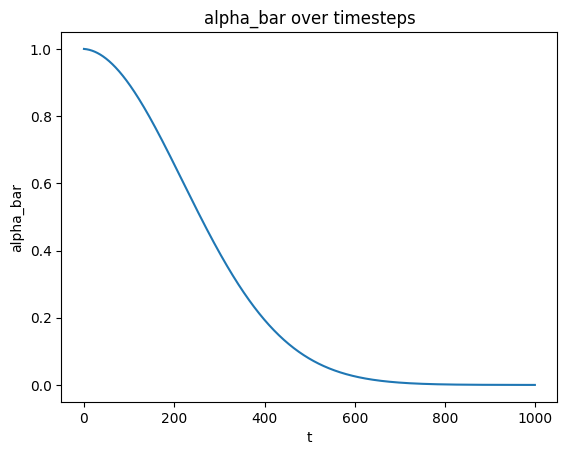

In [7]:
# Linear beta schedule; linear noise schedule
def linear_beta_schedule(T, beta_start=1e-4, beta_end=2e-2, device="cpu"):
    betas = torch.linspace(beta_start, beta_end, T, device=device) # define the noise schedule
    alphas = 1.0 - betas # used in reverse updates
    alpha_bars = torch.cumprod(alphas, dim=0) # compute cumulative signal retention; used in both forward diffusion and reverse sampling
    return betas, alphas, alpha_bars

T = 1000
device = "cuda" if torch.cuda.is_available() else "cpu"
betas, alphas, alpha_bars = linear_beta_schedule(T, device=device)

# ----------------------- Sanity check

print("betas:", betas.shape, "range", (betas.min().item(), betas.max().item()))
print("alphas:", alphas.shape, "range", (alphas.min().item(), alphas.max().item()))
print("alpha_bars:", alpha_bars.shape, "range", (alpha_bars.min().item(), alpha_bars.max().item()))


plt.plot(alpha_bars.detach().cpu())
plt.title("alpha_bar over timesteps")
plt.xlabel("t")
plt.ylabel("alpha_bar")
plt.show()


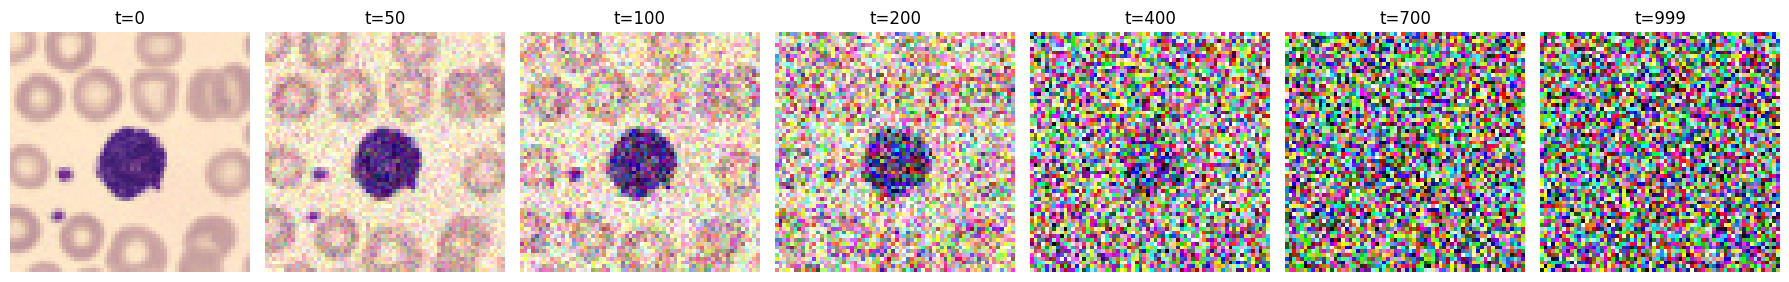

In [8]:
# Visualize what happens to a real image as t increases
# Let's visualize it

def q_sample(x0, t, alpha_bars):
    """
    It generates a noisy version xt of a clean image x0 by adding Gaussian noise according to the diffusion schedule at timestep t.
    x0: (C,H,W) in [-1,1]
    t: int
    """
    ab = alpha_bars[t]
    eps = torch.randn_like(x0)
    xt = torch.sqrt(ab) * x0 + torch.sqrt(1 - ab) * eps
    return xt

# pick the first image from dataset
x0 = ds[0].to(device)

ts = [0, 50, 100, 200, 400, 700, 999]
fig, axes = plt.subplots(1, len(ts), figsize=(18, 3))

for i, t in enumerate(ts):
    xt = q_sample(x0, t, alpha_bars)
    xt_vis = (xt.clamp(-1, 1) + 1) / 2  # back to [0,1]
    axes[i].imshow(xt_vis.detach().cpu().permute(1,2,0))
    axes[i].set_title(f"t={t}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# This schedule:
# - transitions smoothly
# - does not destroy the image too early
# - fully destroys it by t ≈ 400–700


## Step 3 - Train a U-Net to predict the noise

Train a neural network (typically a U-Net) that takes as input:

- the noised image $x_t$
- the timestep $t$

and outputs:

- the model’s estimate of the noise  
  $$
  \hat{\epsilon} = \mathrm{model}(x_t, t)
  $$

The training objective is the mean squared error between the true noise \(\epsilon\) and the predicted noise $\hat{\epsilon}$:

$$
\mathcal{L} = \|\epsilon - \hat{\epsilon}\|^2
$$

**Key idea**

The model is not directly predicting the clean image $x_0$.  
Instead, it learns: *"Given a noisy image at noise level $t$, what noise was added?"*



In [9]:

def sinusoidal_time_embedding(timesteps: torch.Tensor, dim: int) -> torch.Tensor:
    """
    Create sinusoidal timestep embeddings.
    IT describes the position of an index in an ordered list.

    Args:
        timesteps: Tensor of shape (B,) containing integer timesteps.
        dim: Dimension of the embedding.

    Returns:
        Tensor of shape (B, dim) with sinusoidal embeddings.
    """
    # Ensure timesteps are floats
    timesteps = timesteps.float()

    device = timesteps.device
    half_dim = dim // 2

    # Compute the frequencies
    exponent = -math.log(10000) / (half_dim - 1)
    frequencies = torch.exp(
        torch.arange(half_dim, device=device) * exponent
    )

    # Outer product: (B, half_dim)
    args = timesteps[:, None] * frequencies[None, :]

    # Sinusoidal embedding
    embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

    # Pad if dim is odd
    if dim % 2 == 1:
        embedding = torch.nn.functional.pad(embedding, (0, 1))

    return embedding


class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_ch) # its' kind of BatchNorm
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)

        self.norm2 = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

        self.time_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim, out_ch)
        )

        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv1(F.silu(self.norm1(x))) # Silu (that are more common in diffusion models) instead of Relu
        # Add time channel
        h = h + self.time_proj(t_emb)[:, :, None, None]
        h = self.conv2(F.silu(self.norm2(h)))
        return h + self.skip(x)



class UNetSmall(nn.Module):
    def __init__(self, in_ch=3, base_ch=64, time_dim=256):
        super().__init__()
        self.time_dim = time_dim

        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )

        self.conv_in = nn.Conv2d(in_ch, base_ch, 3, padding=1)

        # Down
        self.rb1 = ResBlock(base_ch, base_ch, time_dim)
        self.down1 = nn.Conv2d(base_ch, base_ch, 4, 2, 1)       # /2

        self.rb2 = ResBlock(base_ch, base_ch*2, time_dim)
        self.down2 = nn.Conv2d(base_ch*2, base_ch*2, 4, 2, 1)   # /4

        self.rb3 = ResBlock(base_ch*2, base_ch*4, time_dim)
        self.down3 = nn.Conv2d(base_ch*4, base_ch*4, 4, 2, 1)   # /8

        # Middle
        self.mid1 = ResBlock(base_ch*4, base_ch*4, time_dim)
        self.mid2 = ResBlock(base_ch*4, base_ch*4, time_dim)

        # Up
        self.up3 = nn.ConvTranspose2d(base_ch*4, base_ch*4, 4, 2, 1)  # x2
        self.urb3 = ResBlock(base_ch*8, base_ch*2, time_dim)

        self.up2 = nn.ConvTranspose2d(base_ch*2, base_ch*2, 4, 2, 1)  # x4
        self.urb2 = ResBlock(base_ch*4, base_ch, time_dim)

        self.up1 = nn.ConvTranspose2d(base_ch, base_ch, 4, 2, 1)      # x8
        self.urb1 = ResBlock(base_ch*2, base_ch, time_dim)

        self.conv_out = nn.Sequential(
            nn.GroupNorm(8, base_ch),
            nn.SiLU(),
            nn.Conv2d(base_ch, 3, 3, padding=1)
        )

    def forward(self, x, t):
        t_emb = sinusoidal_time_embedding(t, self.time_dim)
        t_emb = self.time_mlp(t_emb)

        x0 = self.conv_in(x)
        x1 = self.rb1(x0, t_emb)
        d1 = self.down1(x1)

        x2 = self.rb2(d1, t_emb)
        d2 = self.down2(x2)

        x3 = self.rb3(d2, t_emb)
        d3 = self.down3(x3)

        m = self.mid1(d3, t_emb)
        m = self.mid2(m, t_emb)

        u3 = self.up3(m)
        u3 = torch.cat([u3, x3], dim=1)
        u3 = self.urb3(u3, t_emb)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, x2], dim=1)
        u2 = self.urb2(u2, t_emb)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, x1], dim=1)
        u1 = self.urb1(u1, t_emb)

        return self.conv_out(u1)  # predicts epsilon


In [10]:
model = UNetSmall(in_ch=3, base_ch=64).to(device)
print("params:", sum(p.numel() for p in model.parameters())/1e6, "M")

params: 7.912195 M


In [11]:
model

UNetSmall(
  (time_mlp): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rb1): ResBlock(
    (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): GroupNorm(8, 64, eps=1e-05, affine=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Sequential(
      (0): SiLU()
      (1): Linear(in_features=256, out_features=64, bias=True)
    )
    (skip): Identity()
  )
  (down1): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (rb2): ResBlock(
    (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): GroupNorm(8, 128, eps=1e-05, affine=True)
    (conv2): Conv2d(128, 128

In [12]:

def q_sample_batch(x0, t, alpha_bars):
    """
    x0: (B, 3, H, W) in [-1,1]
    t:  (B,) int64
    """
    B = x0.shape[0]
    ab = alpha_bars[t].view(B, 1, 1, 1)

    eps = torch.randn_like(x0)
    xt = torch.sqrt(ab) * x0 + torch.sqrt(1 - ab) * eps
    return xt, eps

opt = optim.AdamW(model.parameters(), lr=2e-4)
loss_fn = nn.MSELoss()

EPOCHS = 6  # small to verify loss decreases

model.train()
for epoch in range(EPOCHS):
    pbar = tqdm(dl, desc=f"epoch {epoch+1}/{EPOCHS}")
    running = 0.0

    for x0 in pbar:
        x0 = x0.to(device)

        # sample random t per image
        t = torch.randint(0, T, (x0.size(0),), device=device).long()

        # forward diffuse
        xt, eps = q_sample_batch(x0, t, alpha_bars)

        # predict noise
        eps_hat = model(xt, t)

        # MSE loss
        loss = loss_fn(eps_hat, eps)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        running += loss.item()
        pbar.set_postfix(loss=running / (pbar.n + 1))

    print(f"epoch {epoch+1} mean loss: {running / len(dl):.4f}")


epoch 1/6: 100%|██████████| 602/602 [10:14<00:00,  1.02s/it, loss=0.0571]


epoch 1 mean loss: 0.0571


epoch 2/6: 100%|██████████| 602/602 [00:40<00:00, 14.73it/s, loss=0.0228]


epoch 2 mean loss: 0.0228


epoch 3/6: 100%|██████████| 602/602 [00:41<00:00, 14.57it/s, loss=0.0191]


epoch 3 mean loss: 0.0191


epoch 4/6: 100%|██████████| 602/602 [00:41<00:00, 14.67it/s, loss=0.0182]


epoch 4 mean loss: 0.0182


epoch 5/6: 100%|██████████| 602/602 [00:41<00:00, 14.59it/s, loss=0.0176]


epoch 5 mean loss: 0.0176


epoch 6/6: 100%|██████████| 602/602 [00:41<00:00, 14.65it/s, loss=0.017]

epoch 6 mean loss: 0.0170


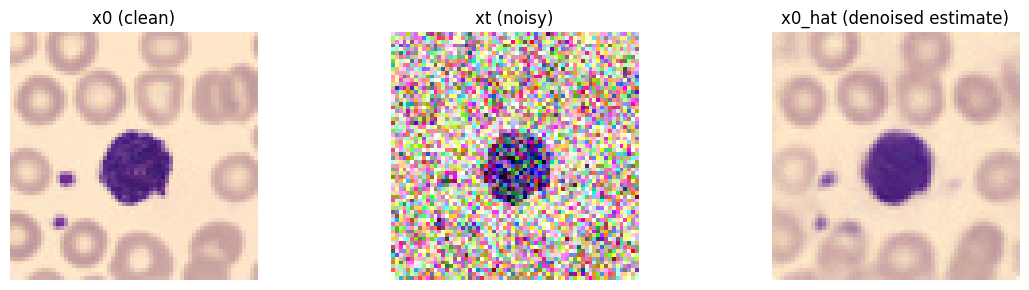

In [13]:
# SAnity check

model.eval()
with torch.no_grad():
    x0 = ds[0].unsqueeze(0).to(device)
    t = torch.tensor([200], device=device).long()

    xt, eps = q_sample_batch(x0, t, alpha_bars)
    eps_hat = model(xt, t)

    # estimate x0 from xt and predicted noise
    ab = alpha_bars[t].view(1,1,1,1)
    x0_hat = (xt - torch.sqrt(1 - ab) * eps_hat) / torch.sqrt(ab)

def show(x, title):
    x = (x.squeeze(0).clamp(-1,1) + 1) / 2
    plt.imshow(x.detach().cpu().permute(1,2,0))
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); show(x0, "x0 (clean)")
plt.subplot(1,3,2); show(xt, "xt (noisy)")
plt.subplot(1,3,3); show(x0_hat, "x0_hat (denoised estimate)")
plt.tight_layout()
plt.show()

# IT looks like this diffusion model is working


## Step 4 - Why timestep conditioning is necessary

The denoising task at $t = 10$ (slightly noisy) is very different from the task at $t = 900$ (almost pure noise).

Therefore, the model must know *which* denoising problem it is solving. This is why the timestep $t$ is provided as an additional input.

**Implementation detail**

- Convert $t$ into an embedding (often sinusoidal, similar to Transformer positional embeddings).
- Inject this embedding into U-Net blocks (e.g., via addition to feature maps after a linear layer).



In [14]:
# Sanity chrck
model.eval()
with torch.no_grad():
    x0 = ds[0].unsqueeze(0).to(device)  # (1,3,H,W)

    # Make one noisy image at a fixed timestep
    t_fixed = torch.tensor([200], device=device).long()
    xt, eps = q_sample_batch(x0, t_fixed, alpha_bars)

    # Now ask the model to predict noise for the same xt but different t
    t1 = torch.tensor([50], device=device).long()
    t2 = torch.tensor([800], device=device).long()

    eps_hat_50  = model(xt, t1)
    eps_hat_800 = model(xt, t2)

    diff = (eps_hat_50 - eps_hat_800).abs().mean().item()

print("Mean abs difference between eps_hat(t=50) and eps_hat(t=800):", diff)


Mean abs difference between eps_hat(t=50) and eps_hat(t=800): 0.5860515236854553


## Sampling (generation) after training

Once training is complete, generation proceeds as follows.

### Step 5 - Start from pure noise

Sample an initial image from a standard Gaussian distribution:

$$
x_T \sim \mathcal{N}(0, I)
$$

This is effectively random static.

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
B = 16
C = 3
H = W = 64  # or 128 if you trained at 128

xT = torch.randn((B, C, H, W), device=device)  # x_T ~ N(0, I)
print(xT.shape, xT.mean().item(), xT.std().item())


torch.Size([16, 3, 64, 64]) 8.915861826608307e-07 1.0029064416885376


### Step 6 - Reverse process (denoise step-by-step)

For $t = T, T-1, \ldots, 1$:

1. Predict the noise in the current image  
   $$
   \hat{\epsilon} = \mathrm{model}(x_t, t)
   $$

2. Apply the DDPM reverse update rule to obtain a slightly less noisy image $x_{t-1}$  
   (this uses the noise schedule parameters and the predicted noise)

**Intuition**

- Each reverse step removes a small amount of noise.
- Over many steps, structure gradually emerges until the result looks like a realistic cell image.

At the end of this process, you obtain a generated sample $x_0$.

In [16]:
# assume betas, alphas, alpha_bars are on device
alpha_bars_prev = torch.cat([torch.tensor([1.0], device=device), alpha_bars[:-1]])

# posterior variance: beta_t * (1 - alpha_bar_{t-1}) / (1 - alpha_bar_t)
posterior_variance = betas * (1.0 - alpha_bars_prev) / (1.0 - alpha_bars)

In [17]:
# DDPM sampling function (reverse process)
@torch.no_grad() #this decorator is to not track all the previous images for gradient calculation; that could eat up lots of memory
def ddpm_sample(model, n_samples, image_size, T, betas, alphas, alpha_bars, posterior_variance, device):
    model.eval()

    x = torch.randn(n_samples, 3, image_size, image_size, device=device)  # x_T

    for t in reversed(range(T)):

        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long) # time stamp

        eps_hat = model(x, t_batch)  # predict noise

        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]

        # compute model mean (mu_theta)
        mean = (1.0 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1.0 - alpha_bar_t)) * eps_hat)

        if t > 0:
            z = torch.randn_like(x)
            var = posterior_variance[t]
            x = mean + torch.sqrt(var) * z
        else:
            x = mean  # final step: no noise

    return x  # in [-1,1] approximately


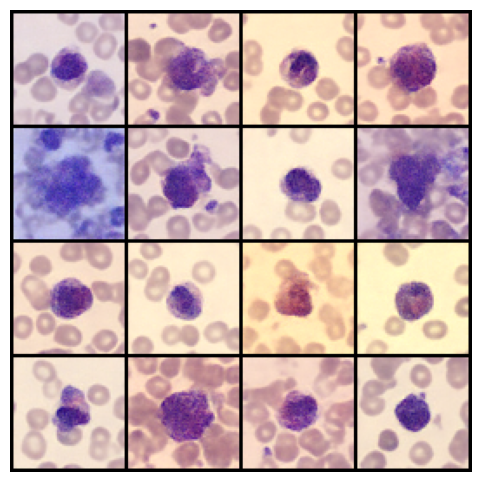

In [18]:
# Generate and visualize samples

samples = ddpm_sample(
    model=model,
    n_samples=16,
    image_size=64,   # must match training
    T=T,
    betas=betas,
    alphas=alphas,
    alpha_bars=alpha_bars,
    posterior_variance=posterior_variance,
    device=device
)

# convert from [-1,1] to [0,1] for viewing
samples_vis = (samples.clamp(-1, 1) + 1) / 2

grid = make_grid(samples_vis, nrow=4)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0).detach().cpu())
plt.axis("off")
plt.show()


The color statistics are correct. H&E color separation is present:

- hematoxylin (purple/blue nuclei)
- eosin (pink background)


Background sometimes dominates. I can see some tiles where:

- RBC rings are strong
- the central cimmune cell is weak or missing

This happens because:

- background occupies more pixels
- the unconditional model learns easy structures first
- class balance is ignored (for now)

#### Possible Improvements

This can be improved with:

- more training steps
- a slightly larger model
